# **Finding Lane Lines on the Road** 

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
from scipy import stats

%matplotlib inline

In [151]:
def show_image(title,img,cmap=None):
    global debug
    if(debug==1):
        #print (title)
        plt.figure()
        plt.title(title)
        plt.imshow(img,cmap)

def yellowgrayscale(image):
    #enhance yellow then find grayscale
    
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # define range of yellow color in HSV
    #lower = np.array([40,40,40])
    #upper = np.array([150,255,255])
        
    #RGB limits
    lower = np.array([80,80,40])
    upper = np.array([255,255,80])
    
    # Threshold the HSV image to get only yellow colors
    mask = cv2.inRange(image, lower, upper)
    #show_image('mask',mask)
 
    # Bitwise-AND mask and original image
    res = cv2.bitwise_and(image,image, mask= mask)
    res = cv2.addWeighted(res, 1.0, image, 1.0, 0)  
    res = grayscale(res)
 
    return res
    
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):

    for line in lines:
        for x1,y1,x2,y2 in line:
            #print (x1,y1,x2,y2)
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)


def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)            

In [3]:
def test_lines(img, lines,title="test_lines"):
    
    if(debug == 1):
        line_img = np.zeros(img.shape, dtype=np.uint8)
        #print ("size=",lines.size)
        draw_lines(line_img, lines,thickness=1)
        show_image(title,line_img,cmap='gray')
    #mark_lanes(line_img,img)
    #plt.imshow(line_img, cmap='gray')
        

In [4]:
def top(img):
    """
        Define where to truncate the image. This function brings hard-coding to one place.
    """
    hardcoding = 0.6
    
    image_height = img.shape[0]
    image_width = img.shape[1]
    image_top = hardcoding*image_height #top is the lowest top x value of region on interest
    image_bottom = 1.0*image_height
    
    return [image_top,image_bottom]

#my modified and new functions
def lane_lines(img, lines):
    """
    `lines` should be the output of a cv2.HoughLinesP.
        
    Returns left lane and right lane in a list.
    """       
    num_lines = lines.shape[0]
    #rlines & llines store y values corresponding top and bottom x values along with weight (length of hf line y2-y1)
    llines = []
    rlines = []
    image_height = img.shape[0]
    image_width = img.shape[1]
    [image_top,image_bottom] = top(img) #top is the lowest top x value of region on interest
    
    #for test drawing of what lines we are selecting
    tl_lines = []
    tr_lines = []
    skip_lines = []
    
    #filter out all the points that have slope outside 80-100 degrees
    for line in lines:
        for x1,y1,x2,y2 in line:
            skipped=True
            if(x2 == x1):
                continue #skip vertical lines
            m = np.round((y2-y1)/(x2-x1),1) #round to 1/10th 
            b = np.round(y2 - m*x2,0) #round to integer
            #if(debug):
                #print("point (x1,y1,x2,y2) ",x1,y1,x2,y2," m,b",m,b,"image_width=",image_width,"image_width",image_width)
            #ignore high slopes and intercept that are not in the image
            if(x1 > 0.3*image_width and  m >.5 and b < 0.5*image_width and b >= -100):
                #find where the line intercepts the image bottom, 
                x_bottom = int((image_bottom -b)/m/10)*10 #round it to 10 pixels
                #find where the line intercepts the top of region of interest,
                x_top = int((image_top -b)/m/10)*10 #round it to 10 pixels
                if(x_bottom > 0.7*image_width and x_bottom < image_width):
                    newline = [x_bottom,x_top,(y2-y1),y2]
                    #print("right line =",newline) 
                    skipped=False
                    rlines.append(newline)
                    tr_lines.append(line)
                    test_lines(img,[line],title=[m,b,x1,x2])
            elif(m<-.5):
                if(b < image_width and x2 < image_width):
                    #find where the line intercepts the image bottom, 
                    x_bottom = int((image_bottom -b)/m/10)*10 #round it to 10 pixels
                    #find where the line intercepts the top of region of interest,
                    x_top = int((image_top -b)/m/10)*10 #round it to 10 pixels
                    if(x_bottom>0 and x_top <0.7*image_width):
                        newline = [x_bottom,x_top,(y1-y2),y1]   
                        llines.append(newline)
                        tl_lines.append(line)
                        skipped=False
                        if(debug):
                            print("left point skipped [x_bottom,x_top,(y1-y2),y1]", [x_bottom,x_top,(y1-y2),y1])
                        test_lines(img,[line],title=[m,b,x1,x2])
                    else:
                        if(debug):
                            print("left point skipped x_bottom > 0:", x_bottom,"or x_top<0.7*image_width:",x_top)
            else:
                if(debug):
                    print("point skipped due to slope,intercept or x2 extending image_width",m,b,x2,image_width)
            if(skipped):
                skip_lines.append(line)
                #print("skipping (x1,y1,x2,y2) ",x1,y1,x2,y2," slope,intercept",m,b)
    
    test_lines(img,skip_lines) 
    new_lines = np.array([np.array(llines),np.array(rlines)])
    #print ("new_lines shape=",new_lines.shape)
    #print ("shapes of llines,rlines=",new_lines[0].shape,new_lines[1].shape)
    return new_lines

def lines_to_lane(img, lines):
    """
    convert lines to single lane based on their weights (length of lines and closeness to car)
    """
    [top_y, bottom_y] = top(img)
    if(len(lines) == 0):
        lane = np.array([0, 0, 0, 0], dtype=np.int32)
        print("no lane found for image_cnt=",image_cnt)
        return lane
      
    #print (lines.size)
    #print (lines)
    #print (np.median(lines,axis=0),np.std(lines,axis=0))      
    median_bottom = np.median(lines,axis=0)[0]
    std_bottom = np.std(lines,axis=0)[0]
    median_top = np.median(lines,axis=0)[1]
    std_top = np.std(lines,axis=0)[1]
    if(debug):
        print("median_bottom,std_bottom,",median_bottom,std_bottom)
        print("std_bottom/median_bottom",(std_bottom/median_bottom))
        print("median_top,std_top,",median_top,std_top)
        print("(std_top/median_top)",(std_top/median_top))
    
    product_sum=0
    bottom_sum=0
    top_sum=0 
    count=0
    for line in lines:
        #print ("line=",line)
        [x_bottom,x_top,length,proximity] = line
        #print ("np.abs(x_top-median_top)",np.abs(x_top-median_top))
        #only chose points that are withing 1 std of mean ??? should it be median?
        if( ((std_bottom/median_bottom) > .15 and np.abs(x_bottom-median_bottom) > std_bottom) or
           ((std_top/median_top) > .15 and np.abs(x_top-median_top) > std_top)):
            if(debug):
                print ("skipping (x_bottom,x_top,length,proximity)", x_bottom,x_top,length,proximity)
        else:
            if(debug):
                print ("good (x_bottom,x_top,length,proximity)", x_bottom,x_top,length,proximity)
            product=length*proximity
            #product=length
            product_sum = product_sum+product
            bottom_xp = product*x_bottom
            bottom_sum = bottom_sum+bottom_xp
            top_xp = product*x_top
            top_sum = top_sum+top_xp
            count=count+1
    
    if(count>0):
        bottom_x = int(bottom_sum/product_sum)
        top_x = int(top_sum/product_sum)
        lane = np.array([bottom_x, bottom_y, top_x, top_y], dtype=np.int32)
    else:
        #cv2.imwrite("test_images/noleft-"+str(image_cnt)+".jpg",img)
        lane = np.array([0, 0, 0, 0], dtype=np.int32)
    if(debug):
        print ("lane=",lane)    
    return lane

def concat_hist_lines(both_lines):
    """
    ' Look these lines to all hist lines going back n days and return those lines
    / image_cnt is the number of this image
    input is a list with two arrays (left,right). each array has a list of lines
    we should return similar list after concatenating both arrays.
    """
    global all_lines
    max_hist = 10
    start = 0
    
    #print("input=",both_lines)
    #print('input list sizes=',len(both_lines[0]),len(both_lines[1]))
    
    if(image_cnt == 1):
        all_lines = [both_lines]
    else:
        all_lines.append(both_lines)
        size=len(all_lines)
        #print("len of all_lines = ",size)
        if(size > max_hist):
            start = size-max_hist
            all_lines = all_lines[start:]
    
    #print("len of all_lines after trunc = ",len(all_lines))
    
    left_list = []
    right_list = []
    for listvalue in all_lines:
        left = listvalue[0]
        for line in left:
            left_list.append(line)
      
        right = listvalue[1]
        for line in right:
            right_list.append(line)
       
    #print('output list sizes=',len(left_list),len(right_list))
    if(len(left_list)==0):
        print("sending zero length line for image_cnt=",image_cnt)
        
    hist_lines = [left_list,right_list]
    
    #print("output",hist_lines)
    return hist_lines
 
def are_lanes_ok(lanes):
    global prev_lanes
    
    #are we here first time?
    if(len(prev_lanes) == 0):
        prev_lanes = lanes
        return lanes
    
    [prev_left_lane,prev_right_lane] = prev_lanes
    [left_lane, right_lane] = lanes
    #print(prev_left_lane,left_lane)
    #print(prev_right_lane,right_lane)
    
    #make sure x co-ordinates are not far apart (100 points) 
    allowed=100
    if(abs(left_lane[0]-prev_left_lane[0]) > allowed or
       abs(left_lane[2]-prev_left_lane[2]) > allowed):
        #too much shift, keep old lane
        print("for image_cnt=", image_cnt, "keeping prev left lane: prev, new ",prev_left_lane, left_lane)
        left_lane = prev_left_lane
 
    if(abs(right_lane[0]-prev_right_lane[0]) > allowed or
       abs(right_lane[2]-prev_right_lane[2]) > allowed):
        #too much shift, keep old lane
        print("for image_cnt=", image_cnt, "keeping prev right lane: prev, new ", prev_right_lane, right_lane)
        right_lane = prev_right_lane

    #print("prev=",prev_lanes)
    lanes = [left_lane, right_lane]
    #print("new lanes=",lanes)
    prev_lanes = lanes
    
    return lanes
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
    lines are drawn between y values of vertices_top and vertices_bottom
        
    Returns an image with hough lines drawn.
    """ 
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    new_lines = lane_lines(img, lines)
    
    #here we should store historic lane_lines together 
    concat_lines = concat_hist_lines(new_lines)
    
    line_img = np.zeros(img.shape, dtype=np.uint8)
    left_lane = lines_to_lane(img, concat_lines[0])  
    right_lane = lines_to_lane(img, concat_lines[1])    
    [left_lane,right_lane] = are_lanes_ok([left_lane,right_lane])
    lanes = np.array([np.array([left_lane]),np.array([right_lane])])
    
    #lanes = lines_to_lanes2(img,new_lines)
    draw_lines(line_img, lanes,thickness=10)

    return line_img

In [5]:
def fetch_test_image(folder,i=83):
    
    image = mpimg.imread('test_images/'+folder+'/test-'+str(i)+'.jpg')
    return image

def fetch_image(i=0):
    
    #reading in an image from test
    images = ['test_images/solidWhiteCurve.jpg',
     'test_images/solidWhiteRight.jpg',
     'test_images/solidYellowCurve.jpg',
     'test_images/solidYellowCurve2.jpg',
     'test_images/solidYellowLeft.jpg',
     'test_images/whiteCarLaneSwitch.jpg',
      'test_images/challenge/test-14.jpg']
    if(i > 6):
        i = 6
    if(i<0):
        i=0
    image = mpimg.imread(images[i])

    return image

In [153]:
def get_houg_lines_image(image):
    """
    reads a color image and returns gray-image with masked region
    """
    # define a region to find the lines
    imshape = image.shape
    image_height=imshape[0]
    image_width=imshape[1]
    vertices_left = 0
    vertices_right = image_width-vertices_left
    vertices_mid = image_width/2
    [vertices_top,vertices_bottom] = top(image)
    
    vertices = np.array([[(vertices_left,vertices_bottom),(vertices_left, vertices_top),
                          (vertices_right, vertices_top), (vertices_right,vertices_bottom)
                         ]], dtype=np.int32)    
    
    masked_image = region_of_interest(image, vertices)
    #show_image("masked_image",masked_image)
    
    #get a grey scale image
    #gray = grayscale(masked_image)
    gray = yellowgrayscale(masked_image)
    #show_image("grayscale",gray,cmap='gray')
    
    #equalize = cv2.equalizeHist(gray) didnt work
    #show_image("equalize",equalize,cmap='gray')
    
    #apply blur
    blur_gray = gaussian_blur(gray,5)
    show_image("gaussian_blur",blur_gray,cmap='gray')

    #apply the canny transform to get edges
    edges = canny(blur_gray, 50,150)
    #show_image("canny",edges,cmap='gray')
    
    #Remask to remove horizontal edges near the top
    vertices = np.array([[(vertices_left,vertices_bottom),(vertices_left, vertices_top+10),
                          (vertices_right, vertices_top+10), (vertices_right,vertices_bottom)
                         ]], dtype=np.int32)
    
    masked_edges = region_of_interest(edges, vertices)
    show_image("masked_edges",masked_edges,cmap='gray')
    
    """
    TODO: Do we need to change these constants in the run?
    """
    rho = 1           # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15    # minimum number of points on a line (intersections in Hough grid cell)
    min_line_len = 20  # minimum number of pixels making up a line
    max_line_gap = 20  # maximum gap in pixels between connectable line segments

    hough_lines_img = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)
    show_image("hough_lines",hough_lines_img,cmap='gray')
    

    return hough_lines_img

In [7]:
def mark_lanes(hough_lines_img, image):
    """
    Takes hough_lines, image as input and returns combined image
    """
    #now let us draw weighted image with hough_lines on top of original image
    #print (hough_lines_img.shape, image.shape)
    blank = np.zeros_like(hough_lines_img)
    color_edges = np.dstack((hough_lines_img, blank, blank))
    combined_image = weighted_img(color_edges,image)
    #show_image("combined_image", combined_image)
    return combined_image
    

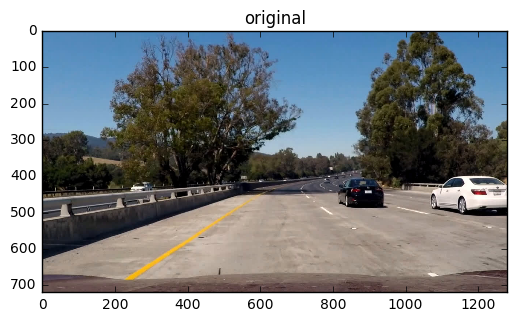

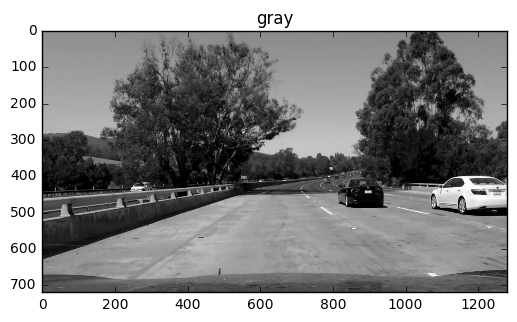

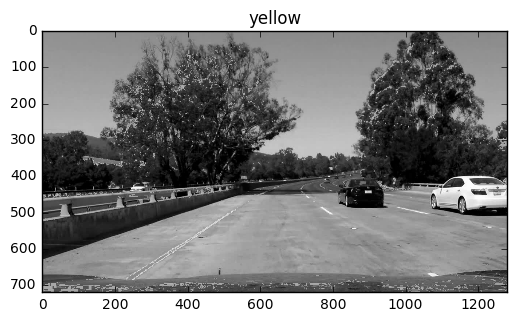

In [152]:
# yellow color detection
debug=1
image = fetch_test_image('challenge',125)
show_image("original",image,cmap=None)

gray = grayscale(image)
show_image("gray",gray,cmap='gray')

yellow = yellowgrayscale(image)
show_image("yellow",yellow ,cmap='gray')

#ygray = grayscale(yellow)
#show_image("ygray",ygray,cmap='gray')




# Main function

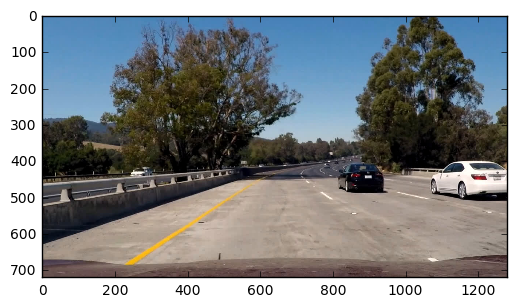

In [155]:
# get a test image
image_cnt=1
all_lines = []
prev_lanes = []

#image = fetch_image(6)
image = fetch_test_image('challenge',125)
plt.imshow(image)

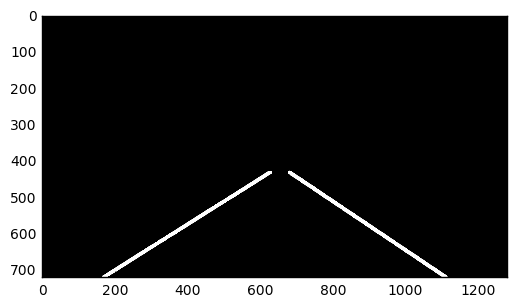

In [156]:
#Find lane markings
debug=0
#image_cnt=1
image_cnt = image_cnt+1
hough_lines_img = get_houg_lines_image(image)
plt.imshow(hough_lines_img, cmap='gray')

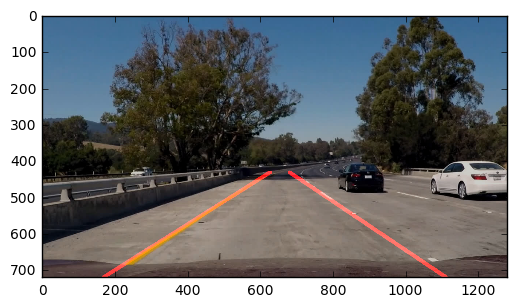

In [157]:
#mark lanes
combined_image = mark_lanes(hough_lines_img, image)
plt.imshow(combined_image)

# Video processing main code

In [159]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes) 
    global image_cnt
    #print("image_cnt = ",image_cnt)
    #if(image_cnt==7):
    #cv2.imwrite("test_images/challenge/test-"+str(image_cnt)+".jpg",image)
    
    hough_lines_img = get_houg_lines_image(image)
    combined_image = mark_lanes(hough_lines_img, image)
    #cv2.imwrite("test_images/challenge/out-"+str(image_cnt)+".jpg",combined_image)
    image_cnt = image_cnt+1
    return combined_image

# Test for Video processing

In [164]:
debug=0
clips = np.array([["solidWhiteRight.mp4","white.mp4"],["solidYellowLeft.mp4","yellow.mp4"]]) 
run = 0 
white_output = clips[run][1] 
clip1 = VideoFileClip(clips[run][0]) 
print (clips[run][0]) 

prev_lanes = []
image_cnt=1
all_lines = []

white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!! 
#clip_images = clip1.write_images_sequence("test_images/white/test-%03d.png", fps=None, verbose=True, withmask=True)
#out_images = white_clip.write_images_sequence("test_images/white/out-%03d.png", fps=None, verbose=True, withmask=True)
%time white_clip.write_videofile(white_output, audio=False)

solidWhiteRight.mp4
[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:07<00:00, 27.71it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 4.98 s, sys: 1.34 s, total: 6.32 s
Wall time: 8.8 s


In [165]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [162]:
debug=0
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
prev_lanes = []

image_cnt=1
all_lines = []

yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:27<00:00, 25.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 17 s, sys: 4.29 s, total: 21.3 s
Wall time: 28.2 s


In [163]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

# Reflections

I improved the code a lot from previous 2 attempts. 

Now I am ignorning lines that are too far to be part of a lane (based on slope, intercept with bottom & top, standard 
deviation from median images selected). I am also giving some weights on how long the line is and how close to the car it is. With these changes all three videos including challenge work well.

I have also added a historic function where you can look at 5 consecutive images to come with a lane marking.
This should help when markings are missing. 



## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [160]:
debug=0
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
#initialize global variables
prev_lanes = []
image_cnt=1
all_lines = []

#clip_images = clip2.write_images_sequence("test_images/challenge/test-%d.jpg", fps=None, verbose=True, withmask=False)
challenge_clip = clip2.fl_image(process_image)

#out_images = challenge_clip.write_images_sequence("test_images/challenge/out-%d.jpg", fps=None, verbose=True, withmask=False)

%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] Writing frames test_images/challenge/out-%d.jpg.

251it [00:51,  5.94it/s]

[MoviePy]: Done writing frames test_images/challenge/out-%d.jpg.

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4



100%|██████████| 251/251 [00:29<00:00,  8.57it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 20.1 s, sys: 2.37 s, total: 22.4 s
Wall time: 31.5 s


In [161]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

In [212]:
image_cnt

118